In [1]:
import h5py, numpy as np, sigpy as sp, sigpy.mri as mr
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
h5_path = "file_brain_AXFLAIR_200_6002467.h5"
slice_idx = 5
resolution = 320
calib_width = 24

In [3]:
with h5py.File(h5_path, "r") as hf:
    kspace = hf["kspace"][:]

kspace = kspace.transpose(1, 0, 2, 3)
ks = kspace[slice_idx]

print("K-space slice shape:", ks.shape)

K-space slice shape: (16, 640, 320)


In [4]:
ecalib = mr.app.EspiritCalib(
    ks[None], calib_width=calib_width, thresh=0.02, crop=0.95, kernel_width=6, device=sp.Device(-1)
)
sens = ecalib.run()[0]
print("Sensitivity map shape:", sens.shape, sens.dtype)

# Compute MVUE
coils_img = sp.ifft(ks, axes=(-2, -1))
num = np.sum(np.conj(sens) * coils_img, axis=0)
denom = np.sum(np.abs(sens) ** 2, axis=0) + 1e-8
img = num / denom

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

Sensitivity map shape: (16, 640, 320) complex64


In [5]:
def center_crop(arr, size=320):
    H, W = arr.shape[-2:]
    sh, sw = (H - size) // 2, (W - size) // 2
    if arr.ndim == 2:
        return arr[sh:sh+size, sw:sw+size]
    elif arr.ndim == 3:
        return arr[..., sh:sh+size, sw:sw+size]

img = center_crop(img)
sens = center_crop(sens)

img = img / (np.percentile(np.abs(img), 99) + 1e-8)

In [6]:
slice_npy = np.stack([img.real, img.imag], axis=0)
mps_npy = sens

for i in range(mps_npy.shape[0]):
    mag = np.abs(mps_npy[i])
    print(f"   [Coil {i}] mag: min={mag.min():.4f}, max={mag.max():.4f}, mean={mag.mean():.4f}")

   [Coil 0] mag: min=0.0000, max=1.0000, mean=0.0512
   [Coil 1] mag: min=0.0000, max=1.0000, mean=0.0543
   [Coil 2] mag: min=0.0000, max=1.0000, mean=0.0710
   [Coil 3] mag: min=0.0000, max=1.0000, mean=0.1006
   [Coil 4] mag: min=0.0000, max=1.0000, mean=0.1381
   [Coil 5] mag: min=0.0000, max=1.0000, mean=0.1883
   [Coil 6] mag: min=0.0000, max=1.0000, mean=0.2822
   [Coil 7] mag: min=0.0000, max=1.0000, mean=0.4228
   [Coil 8] mag: min=0.0000, max=1.0000, mean=0.5144
   [Coil 9] mag: min=0.0000, max=1.0000, mean=0.3739
   [Coil 10] mag: min=0.0000, max=1.0000, mean=0.2574
   [Coil 11] mag: min=0.0000, max=1.0000, mean=0.1901
   [Coil 12] mag: min=0.0000, max=1.0000, mean=0.1300
   [Coil 13] mag: min=0.0000, max=1.0000, mean=0.0849
   [Coil 14] mag: min=0.0000, max=1.0000, mean=0.0605
   [Coil 15] mag: min=0.0000, max=1.0000, mean=0.0527


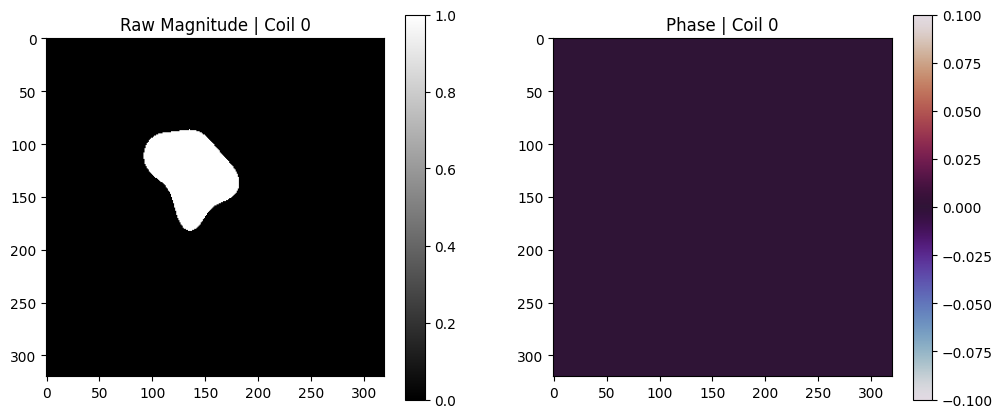

In [7]:
coil_idx = 0
mag = np.abs(sens[coil_idx])
phase = np.angle(sens[coil_idx])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mag, cmap='gray')
plt.title(f"Raw Magnitude | Coil {coil_idx}")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(phase, cmap='twilight')
plt.title(f"Phase | Coil {coil_idx}")
plt.colorbar()
plt.show()

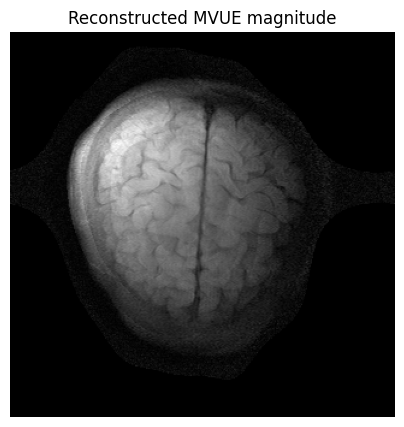

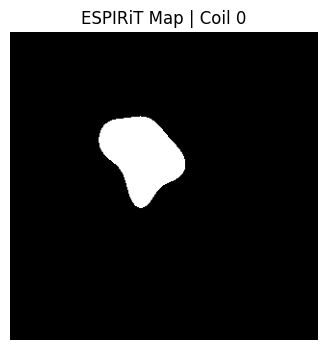

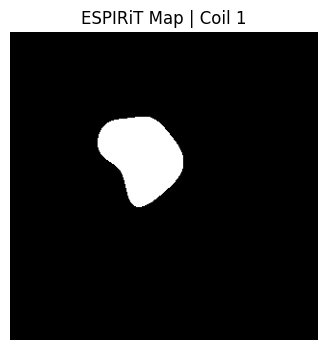

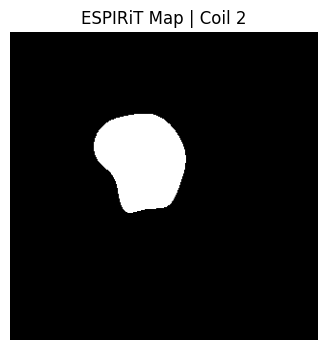

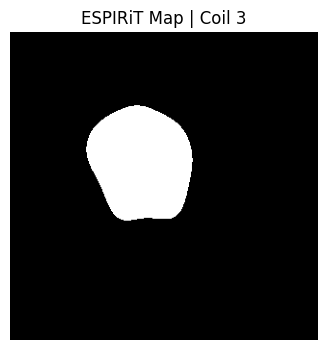

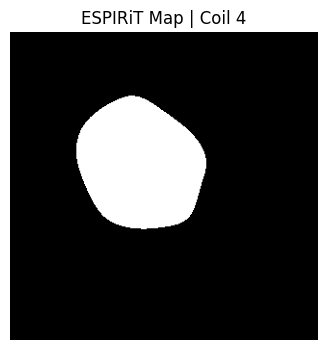

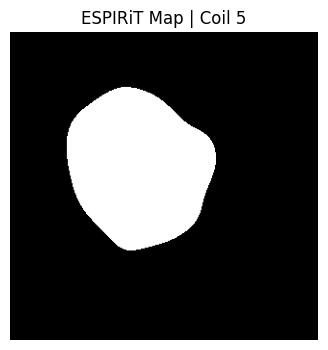

In [8]:
plt.figure(figsize=(5,5))
plt.imshow(np.abs(img), cmap='gray')
plt.title("Reconstructed MVUE magnitude")
plt.axis("off")
plt.show()

for i in range(min(6, sens.shape[0])):
    plt.figure(figsize=(4,4))
    plt.imshow(np.abs(sens[i]), cmap='gray')
    plt.title(f"ESPIRiT Map | Coil {i}")
    plt.axis("off")
    plt.show()